# A Big Dam Problem:
# Identifying critical landscapes around the globe that will be affected by future dam construction.
Contributors: Lauren Herwehe, University of Colorado, Boulder and Stephanie L. Shepherd, Auburn University

## We should give a dam

Many scientists believe we may be on the cusp of the sixth Mass Extinction in Earth’s history, due to human impact on the environment (1). Since the early 20th Century the majority of major rivers around the globe have been impounded or diverted to harness the power of water for energy production, transportation, flood control, water storage, and even recreation (2, 3). Although we as a society benefit greatly from the construction of these engineering marvels, dams have a dramatic impact on river ecosystems. A dam drastically slows water flow, trapping sediment, fish, and water upstream as the reservoir fills flooding the river valley. As a result both the river habitats and the riparian habitats are lost. Downstream of the dam water flow is strictly controlled, often eliminating the natural annual cycles of flooding that supplied sediment and nutrients to the floodplain. When water flow exceeds the storage capacity of the dam, the water released often causes catastrophic flooding downstream. Even as the water rushes out the necessary sediment, nutrients, and organisms are for the most part still trapped behind the dam. Finally dam construction alters the aesthetics of beautiful landscapes around the world and threatening freshwater and terrestrial species (4). Thousands of new dams are proposed globally that will potential impact protected areas such as National Parks, UNESCO World Heritage Sites, and Ramsar Sites adjacent to rivers.

This project is being undertaken in collaboration with the World Wildlife Foundation for the purpose of identifying critical habitats that will potentially be impacted by future dam construction through the analysis of existing datasets. 

## Gathering the Data
Various organizations and researchers have gathered information about our river around the globe that we have leveraged to identify protected areas that are downstream from proposed dams.  

### Free Flowing Rivers
This database contains hydrographic information for all major rivers across the globe. Of particular interest for this work is the Degree of Regulation (DOR) was calculated for each river reach in the database.  DOR is an index that represents how water storage behind a dam will impact the flow of river reaches downstream.  It is reported as a percent, where 0% is a free flowing river and 100% is a reach where the flow is completely altered by a dam.

https://www.nature.com/articles/s41586-019-1379-9
https://figshare.com/articles/Mapping_the_world_s_free-flowing_rivers_data_set_and_technical_documentation/7688801

### Current and Future Dam Database
Global Dam Watch, a collaboration between NGOs and academic institutions, has created and made publicly available three databases that document current and proposed large dams (capacity of >....)across the globe. http://globaldamwatch.org/data/
* Global Georeferenced Database of Dams (GOODD)
* Global Reservoir and Dam Database (GRanD)
* Future Hydropower Reservoirs and Dams (FHReD)

### World Database of Protected Areas
The World Database of Protected Areas (WDPA) is a global database of terrestrial and marine protected areas developed and curated by the International Union for the Conservation of Nature and the United Nations Environmental Programme. https://www.iucn.org/theme/protected-areas/our-work/quality-and-effectiveness/world-database-protected-areas-wdpa

## Asking the Right Questions

Pulling all these data sets together allows us to start asking where are new dams going to be built? And how many protected areas are close enough to these dams to potentially be affected? 

First we overlayed the river reaches (a segment of river channel between two junctions with other channels) that currently have some Degree of Regulation (DOR) with the protected areas (Figure 1). In order to compare the magnitude of regulation the data was divided into group - < 5%, 5-10%, 10-15%, 15-20%, and over 20%.  All river reaches with a DOR of 0% are excluded from these images. Then we hid all river reaches that did not correspond with a protected area (Figure 2). Finally we subtracted the current DOR value from the proposed dam DOR value to find out which areas would have an increase in regulation (Figure 3).

(We need to expand our explanation and possibly use fewer maps to illustrate the process, depends on what we decide to communicate. Do we want to include more of the process of data analysis, i.e. how to make the sausage)

In [1]:
# Imports
import warnings
import os
import sys

import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import earthpy as et
import earthpy.plot as ep
import contextily as ctx

In [2]:
# Check path and set working directory.
wd_path = os.path.join(et.io.HOME, 'earth-analytics', 'data')
if os.path.exists(wd_path):
    os.chdir(wd_path)
else:
    print("Path does not exist")

In [3]:
# Download Data stored on figshare
# Free flowing rivers current DOR
et.data.get_data(url="https://ndownloader.figshare.com/files/23273213")

# Free flowing rivers future DOR
et.data.get_data(url="https://ndownloader.figshare.com/files/23273216")

# World Database of Protected Areas - split by continent
et.data.get_data(url="https://ndownloader.figshare.com/files/23354894")

# Ramsar Sites
et.data.get_data(url="https://ndownloader.figshare.com/files/22507082")

# Country boundaries
et.data.get_data(url="https://ndownloader.figshare.com/files/22507058")

# Continent boundaries
et.data.get_data(url="https://ndownloader.figshare.com/files/23392280")

# Continent-country csv
et.data.get_data(url="https://ndownloader.figshare.com/files/23393756")

'C:\\Users\\lherwehe\\earth-analytics\\data\\earthpy-downloads\\continent-country.csv'

In [4]:
# Custon Function
def all_pa_country(wdpa_polys, ramsar_polys, country_name):
    """ This function takes a country name, WDPA polygons, and Ramsar Polygons, and returns a multipolygon feature of 
    the World Database of Protected Areas merged with the ramsar areas for that country.

    Parameters
    ----------
    country_name: str
        Three letter country code for the country to be analyzed.
    wdpa_polys: gdf
        The feature with the WDPA polygons for the selected country.
    ramsar_polys: gdf
        The feature with the ramsar polygons for the selected country.

    Returns
    -------
    wdpa_ramsar: gdf
        A gdf of both the ramsar and WDPA protected areas for the country.
    """
    # Remove ramsar areas from WDPA dataset
    try:
        wdpa_polys.set_index('DESIG', inplace=True)
        wdpa_polys.drop(
            "Ramsar Site, Wetland of International Importance", inplace=True)
    except:
        print('No ramsar areas in WDPA dataset.')

    # Remove duplicates from WDPA dataset (areas tagged by both state and local authorities)
    try:
        wdpa_polys.set_index('NAME', inplace=True)
        wdpa_polys.drop_duplicates(subset=None,
                                   keep='first', inplace=False)
    except:
        print('No duplicates in the WDPA dataset.')

    # Pull out the ramsar areas for the continent or country and merge with protected areas
    ramsar_polys = ramsar_polys[ramsar_polys["PARENT_ISO"] == country_name]
    wdpa_polys = wdpa_polys[wdpa_polys["PARENT_ISO"] == country_name]
    wdpa_ramsar = wdpa_polys.append(ramsar_polys, 'sort=True')

    return wdpa_ramsar

In [5]:
# Custon Function
def all_pa_continent(wdpa_polys, ramsar_polys, cont_name):
    """ This function takes WDPA polygons for a continent and global ramsar polygons and returns a multipolygon feature 
    of the World Database of Protected Areas merged with the ramsar areas for that continent.

    Parameters
    ----------
    wdpa_polys: gdf
        The feature with the WDPA polygons for the selected continent.
    ramsar_polys: gdf
        The feature with all global ramsar polygons.
    cont_name: str
        The name of the selected continent.

    Returns
    -------
    wdpa_ramsar: gdf
        A gdf of both the ramsar and WDPA protected areas for the continent.
    """
    # Remove ramsar areas from WDPA dataset
    try:
        wdpa_polys.set_index('DESIG', inplace=True)
        wdpa_polys.drop(
            "Ramsar Site, Wetland of International Importance", inplace=True)
    except:
        print('No ramsar areas in WDPA dataset.')

    # Remove duplicates from WDPA dataset (areas tagged by both state and local authorities)
    try:
        wdpa_polys.set_index('NAME', inplace=True)
        wdpa_polys.drop_duplicates(subset=None,
                                   keep='first', inplace=False)
    except:
        print('No duplicates in the WDPA dataset.')

    # Pull out the ramsar areas for the continent or country and merge with protected areas
    ramsar_polys = ramsar_polys[ramsar_polys["continent"] == cont_name]
    wdpa_ramsar = wdpa_polys.append(ramsar_polys, 'sort=True')

    return wdpa_ramsar

In [6]:
# Open continent & country borders & ISOs
country_borders = gpd.read_file(os.path.join(wd_path, "earthpy-downloads", "country-borders",
                                             "99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp"))

continent_iso = pd.read_csv(os.path.join(wd_path, "earthpy-downloads",
                                         "continent-country.csv"))

continent_borders = gpd.read_file(os.path.join(wd_path, "earthpy-downloads", "continent-poly",
                                               "Continents.shp"))

# Reproject data to World Equidistant Cylindrical, datum WGS84, units meters, EPSG 4087
country_borders = country_borders.to_crs('epsg:4087')
continent_borders = continent_borders.to_crs('epsg:4087')

C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [7]:
# Open ramsar areas
ramsar_polys = gpd.read_file(os.path.join(
    "earthpy-downloads", "ramsar-site-data", "ramsar-boundaries",
    "features_publishedPolygon.shp"))

# Rename ramsar columns to match WDPA
try:
    ramsar_polys = ramsar_polys.rename(
        columns={"iso3": "PARENT_ISO", "officialna": "NAME", "area_off": "Shape_Area"})
except:
    print('Ramsar column names already match WDPA dataset.')

# Merge continent names with ramsar data for analyzing by continent
ramsar_polys = pd.merge(ramsar_polys, continent_iso,
                        left_on='PARENT_ISO', right_on='ISO3')

# Data cleaning - take only necessary ramsar columns
ramsar_polys = ramsar_polys[['NAME', 'PARENT_ISO',
                             'Shape_Area', 'continent', 'geometry']]

# Reproject ramsar data to  World Equidistant Cylindrical, datum WGS84, units meters, EPSG 4087
ramsar_polys = ramsar_polys.to_crs('epsg:4087')

C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [8]:
# Open current DOR shapefiles
dor_0to5 = gpd.read_file(os.path.join(wd_path,
                                      "earthpy-downloads", "DOR_Binned", "DOR_0to5.shp"))
dor_5to10 = gpd.read_file(os.path.join(wd_path,
                                       "earthpy-downloads", "DOR_Binned", "DOR_5to10.shp"))
dor_10to15 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "DOR_Binned", "DOR_10to15.shp"))
dor_15to20 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "DOR_Binned", "DOR_15to20.shp"))
dor_over20 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "DOR_Binned", "DOR_over20.shp"))

# Open planned DOR shapefiles
dor_pla_0to5 = gpd.read_file(os.path.join(wd_path,
                                          "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_0to5.shp"))
dor_pla_5to10 = gpd.read_file(os.path.join(wd_path,
                                           "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_5to10.shp"))
dor_pla_10to15 = gpd.read_file(os.path.join(wd_path,
                                            "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_10to15.shp"))
dor_pla_15to20 = gpd.read_file(os.path.join(wd_path,
                                            "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_15to20.shp"))
dor_pla_over20 = gpd.read_file(os.path.join(wd_path,
                                            "earthpy-downloads", "DOR_PLA_Binned", "DOR_PLA_over20.shp"))

In [9]:
# Get all current rivers in selected continent
all_rivers_0to5_africa = dor_0to5[dor_0to5['CONTINENT'] == "Africa"]
all_rivers_5to10_africa = dor_5to10[dor_5to10['CONTINENT'] == "Africa"]
all_rivers_10to15_africa = dor_10to15[dor_10to15['CONTINENT'] == "Africa"]
all_rivers_15to20_africa = dor_15to20[dor_15to20['CONTINENT'] == "Africa"]
all_rivers_over20_africa = dor_over20[dor_over20['CONTINENT'] == "Africa"]

# Get all current rivers in selected continent
all_rivers_pla_0to5_africa = dor_pla_0to5[dor_pla_0to5['CONTINENT'] == "Africa"]
all_rivers_pla_5to10_africa = dor_pla_5to10[dor_pla_5to10['CONTINENT'] == "Africa"]
all_rivers_pla_10to15_africa = dor_pla_10to15[dor_pla_10to15['CONTINENT'] == "Africa"]
all_rivers_pla_15to20_africa = dor_pla_15to20[dor_pla_15to20['CONTINENT'] == "Africa"]
all_rivers_pla_over20_africa = dor_pla_over20[dor_pla_over20['CONTINENT'] == "Africa"]

# Get all current rivers in selected country
all_rivers_0to5_nga = dor_0to5[dor_0to5['ISO_NAME'] == "Nigeria"]
all_rivers_5to10_nga = dor_5to10[dor_5to10['ISO_NAME'] == "Nigeria"]
all_rivers_10to15_nga = dor_10to15[dor_10to15['ISO_NAME'] == "Nigeria"]
all_rivers_15to20_nga = dor_15to20[dor_15to20['ISO_NAME'] == "Nigeria"]
all_rivers_over20_nga = dor_over20[dor_over20['ISO_NAME'] == "Nigeria"]

In [10]:
# For loop to (1) calculating difference in DOR between planned and current, (2) pulling only rivers with class > 3,
# (3) projecting rivers, (4) buffer by 1/100 km to become polys for overlay fuction, (5) pull only needed columns

gdf_list = [all_rivers_0to5_africa, all_rivers_5to10_africa, all_rivers_10to15_africa, all_rivers_15to20_africa, all_rivers_over20_africa,
            all_rivers_pla_0to5_africa, all_rivers_pla_5to10_africa, all_rivers_pla_10to15_africa, all_rivers_pla_15to20_africa, all_rivers_pla_over20_africa]
river_list_prj = []

for shp in gdf_list:
    shp['DOR_DIFF'] = shp['DOR_PLA'] - shp['DOR']
    shp = shp[shp.RIV_CLASS >= 3]
    shp = shp.to_crs('epsg:4087')
    shp['geometry'] = shp.buffer(100)
    shp = shp[['LENGTH_KM', 'RIV_ORD', 'RIV_CLASS', 'CONTINENT',
               'ISO_NAME', 'BAS_NAME', 'DOR', 'DOR_PLA', 'DOR_DIFF', 'Shape_Leng', 'geometry']]
    river_list_prj.append(shp)

# Re-assign names based on list index
dor_0to5 = river_list_prj[0]
dor_5to10 = river_list_prj[1]
dor_10to15 = river_list_prj[2]
dor_15to20 = river_list_prj[3]
dor_over20 = river_list_prj[4]

dor_pla_0to5 = river_list_prj[5]
dor_pla_5to10 = river_list_prj[6]
dor_pla_10to15 = river_list_prj[7]
dor_pla_15to20 = river_list_prj[8]
dor_pla_over20 = river_list_prj[9]

# Concatanate all rivers gdfs for easier analysis later
all_rivers = pd.concat([dor_0to5, dor_5to10, dor_10to15,
                        dor_15to20, dor_over20], axis=0)

# Remove rivers that have DOR_DIFF of 0
all_rivers_lg = all_rivers[all_rivers.DOR_DIFF > 0]

C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

In [11]:
# Analyze Africa
wdpa_africa_polys = gpd.read_file(os.path.join(wd_path,
                                               "earthpy-downloads", "WDPA_Africa", "WDPA_Africa.shp"))

# Data cleaning - remove polygons with no area & take only the needed columns from WDPA dataset
wdpa_africa_polys = wdpa_africa_polys[wdpa_africa_polys.geometry != None]

# Merge continent africames with WDPA data for aafricalyzing by continent
wdpa_africa_polys = pd.merge(wdpa_africa_polys, continent_iso,
                             left_on='PARENT_ISO', right_on='ISO3')

# Take only the columns we need
wdpa_africa_polys = wdpa_africa_polys[[
    'NAME', 'DESIG', 'PARENT_ISO', 'GIS_AREA', 'continent', 'geometry']]

# Reporject WDPA data
wdpa_africa_polys = wdpa_africa_polys.to_crs('epsg:4087')

# Get the combined WDPA & ramsar areas for selected continent
wdpa_ramsar_africa = all_pa_continent(
    wdpa_africa_polys, ramsar_polys, "Africa")

# Getting river length affected
# Overlay current rivers on protected areas for selected continent to get ONLY rivers the overlap PAs
river_overlap_africa = gpd.overlay(
    wdpa_ramsar_africa, all_rivers_lg, how='intersection')

# Getting protected areas affected
# Overlay projected rivers on pas for selected continent to get ONLY pas that overlap rivers
pa_overlap_africa = gpd.overlay(
    river_overlap_africa, wdpa_ramsar_africa, how='intersection')

# Get a list of countries in each continent for calculating lengths/areas by country later
africa_countries = continent_iso[continent_iso.continent == 'Africa']

# Create empty lists
country_sums = []
area_sums = []
countries = []

# Sum up the total river length affected by country in the continent
for country in africa_countries.ISO3:
    country_sums.append((
        river_overlap_africa.loc[river_overlap_africa['PARENT_ISO'] == country, 'LENGTH_KM'].sum()).round(0))
    area_sums.append((
        pa_overlap_africa.loc[pa_overlap_africa['PARENT_ISO_1'] == country, 'Shape_Area_1'].sum()).round(0))
    countries.append(country)

 # Create a pandas dataframe of lengths and areas affected
africa_affected = pd.DataFrame(list(zip(countries, country_sums, area_sums)), columns=[
    'Country', 'Affected_KM', 'Affected_Area'])

africa_affected = africa_affected[africa_affected.Affected_KM != 0]

C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [12]:
# Get all current rivers in selected country & buffer to look nicer on map
all_rivers_0to5_nga = (
    dor_0to5[dor_0to5['ISO_NAME'] == "Nigeria"]).buffer(1000)
all_rivers_5to10_nga = (
    dor_5to10[dor_5to10['ISO_NAME'] == "Nigeria"]).buffer(1000)
all_rivers_10to15_nga = (
    dor_10to15[dor_10to15['ISO_NAME'] == "Nigeria"]).buffer(1000)
all_rivers_15to20_nga = (
    dor_15to20[dor_15to20['ISO_NAME'] == "Nigeria"]).buffer(1000)
all_rivers_over20_nga = (
    dor_over20[dor_over20['ISO_NAME'] == "Nigeria"]).buffer(1000)

In [13]:
# Get the combined WDPA & ramsar areas for seleced country for plotting
wdpa_ramsar_nga = all_pa_country(wdpa_africa_polys, ramsar_polys, 'NGA')

# Overlay current rivers on protected areas for selected country & buffer to look nicer on map
rivers_0to5_nga = (gpd.overlay(
    wdpa_ramsar_nga, dor_0to5, how='intersection').buffer(1000))
rivers_5to10_nga = (gpd.overlay(
    wdpa_ramsar_nga, dor_5to10, how='intersection').buffer(1000))
rivers_10to15_nga = (gpd.overlay(
    wdpa_ramsar_nga, dor_10to15, how='intersection').buffer(1000))
rivers_15to20_nga = (gpd.overlay(
    wdpa_ramsar_nga, dor_15to20, how='intersection').buffer(1000))
rivers_over20_nga = (gpd.overlay(
    wdpa_ramsar_nga, dor_over20, how='intersection').buffer(1000))

# Overlay proposed rivers on protected areas for selected country & buffer to look nicer on map
rivers_pla_0to5_nga = (gpd.overlay(
    wdpa_ramsar_nga, dor_pla_0to5, how='intersection').buffer(1000))
rivers_pla_5to10_nga = (gpd.overlay(
    wdpa_ramsar_nga, dor_pla_5to10, how='intersection').buffer(1000))
rivers_pla_10to15_nga = (gpd.overlay(
    wdpa_ramsar_nga, dor_pla_10to15, how='intersection').buffer(1000))
rivers_pla_15to20_nga = (gpd.overlay(
    wdpa_ramsar_nga, dor_pla_15to20, how='intersection').buffer(1000))
rivers_pla_over20_nga = (gpd.overlay(
    wdpa_ramsar_nga, dor_pla_over20, how='intersection').buffer(1000))

No ramsar areas in WDPA dataset.
No duplicates in the WDPA dataset.


C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [14]:
# Get country border for plottingnga_border = country_borders[country_borders['CNTRY_NAME'] == "Nigeria"]

NameError: name 'nga_border' is not defined

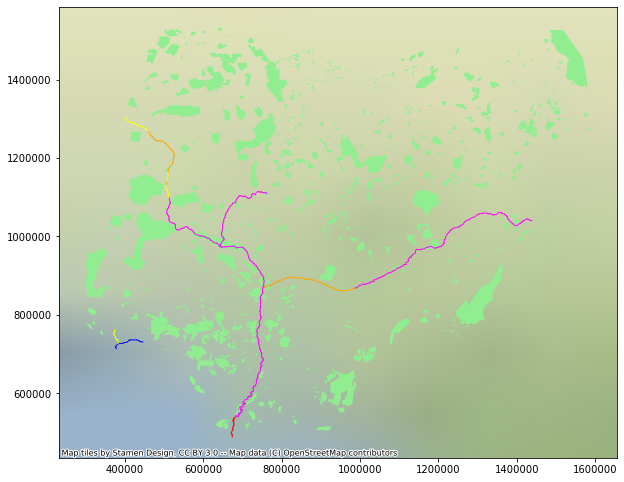

In [15]:
# Plot all rivers and all protected areas for selected country
# Create legend
black_line = mlines.Line2D([], [], color='black', label='Country Border')
blue_line = mlines.Line2D([], [], color='blue', label='0 to 5')
yellow_line = mlines.Line2D([], [], color='yellow', label='5 to 10')
orange_line = mlines.Line2D([], [], color='orange', label='10 to 15')
red_line = mlines.Line2D([], [], color='red', label='15 to 20')
magenta_line = mlines.Line2D([], [], color='magenta', label='20 plus')
lightgreen_patch = mpatches.Patch(color='lightgreen', label='Protected Area')

fig, ax = plt.subplots(figsize=(10, 10))
wdpa_ramsar_nga.plot(ax=ax, color="lightgreen")
all_rivers_0to5_nga.plot(ax=ax,
                         color='blue')
all_rivers_5to10_nga.plot(ax=ax,
                          color='yellow')
all_rivers_10to15_nga.plot(ax=ax,
                           color='orange')
all_rivers_15to20_nga.plot(ax=ax, color='red')
all_rivers_over20_nga.plot(ax=ax,
                           color='magenta')
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=0)
nga_border.plot(ax=ax, color="none",  edgecolor="black", linewidth=2)
ax.set_title(
    'Figure 1: All Protected Areas\n And Rivers by Degree of Regulation in Nigeria', size=22)
ax.set_axis_off()
ax.legend(handles=[black_line, blue_line, yellow_line, orange_line, red_line, magenta_line, lightgreen_patch],
          fontsize=15,
          frameon=True,
          loc=('lower right'), bbox_to_anchor=(1.4, .5),
          title="LEGEND")

In [ ]:
# Plot all current rivers and that overlap protected areas for selected country
# Adding a title to the whole figure
fig.suptitle(
    "All Current & Planned Rivers Overlapping Protected Areas \n in Nigeria by Degree of Regulation (DOR)", fontsize=22)

# Defining plot space
fig, ax1 = plt.subplots(figsize=(5, 5))
wdpa_ramsar_nga.plot(ax=ax1, color="lightgreen")
rivers_0to5_nga.plot(ax=ax1,
                     color='blue')
rivers_5to10_nga.plot(ax=ax1,
                      color='yellow')
rivers_10to15_nga.plot(ax=ax1,
                       color='orange')
rivers_15to20_nga.plot(ax=ax1, color='red')
rivers_over20_nga.plot(ax=ax1,
                       color='magenta')
ctx.add_basemap(ax1, url=ctx.providers.Stamen.Terrain, zoom=0)
nga_border.plot(ax=ax1, color="none",  edgecolor="black", linewidth=2)
ax1.set_title(
    'Figure 2: Current Rivers DOR', size=18)
ax1.set_axis_off()

# Plot all planned rivers and that overlap protected areas for selected country
fig, ax2 = plt.subplots(figsize=(5, 5))
wdpa_ramsar_nga.plot(ax=ax2, color="lightgreen")
wdpa_ramsar_nga.plot(ax=ax2, color="lightgreen")
rivers_pla_0to5_nga.plot(ax=ax2,
                         color='blue')
rivers_pla_5to10_nga.plot(ax=ax2,
                          color='yellow')
rivers_pla_10to15_nga.plot(ax=ax2,
                           color='orange')
rivers_pla_15to20_nga.plot(ax=ax2, color='red')
rivers_pla_over20_nga.plot(ax=ax2,
                           color='magenta')
ctx.add_basemap(ax2, url=ctx.providers.Stamen.Terrain, zoom=0)
nga_border.plot(ax=ax2, color="none",  edgecolor="black", linewidth=2)
ax2.set_title(
    'Figure 3: Planned Rivers DOR', size=18)
ax2.set_axis_off()
ax2.text(0.5, -0.2, "Data Sources: Free Flowing Rivers Dataset World Database of Protected Areas Ramsar Areas",
         size=12, ha="center", transform=ax2.transAxes)
fig.legend(handles=[black_line, blue_line, yellow_line, orange_line, red_line, magenta_line, lightgreen_patch],
           fontsize=15,
           frameon=True,
           loc='lower right', bbox_to_anchor=(1.5, 1.0),
           title="LEGEND")

In [ ]:
# Get continent border for plotting
africa_border = continent_borders[continent_borders['CONTINENT'] == "Africa"]

# Buffer rivers for nicer map
dor_0to5 = dor_0to5.buffer(5000)
dor_5to10 = dor_5to10.buffer(5000)
dor_10to15 = dor_10to15.buffer(5000)
dor_15to20 = dor_15to20.buffer(5000)
dor_over20 = dor_over20.buffer(5000)

In [ ]:
# Plot all rivers and all protected areas for selected continent
# Create legend
black_line = mlines.Line2D([], [], color='black', label='Country Border')
blue_line = mlines.Line2D([], [], color='blue', label='0 to 5')
yellow_line = mlines.Line2D([], [], color='yellow', label='5 to 10')
orange_line = mlines.Line2D([], [], color='orange', label='10 to 15')
red_line = mlines.Line2D([], [], color='red', label='15 to 20')
magenta_line = mlines.Line2D([], [], color='magenta', label='20 plus')
lightgreen_patch = mpatches.Patch(color='lightgreen', label='Protected Area')

fig, ax = plt.subplots(figsize=(15, 15))
africa_border.plot(ax=ax, color="none",  edgecolor="black", linewidth=2)
wdpa_ramsar_africa.plot(ax=ax, color="lightgreen", edgecolor='none')
dor_0to5.plot(ax=ax,
              color='blue', edgecolor='none')
dor_5to10.plot(ax=ax,
               color='yellow', edgecolor='none')
dor_10to15.plot(ax=ax,
                color='orange', edgecolor='none')
dor_15to20.plot(ax=ax,
                color='red', edgecolor='none')
dor_over20.plot(ax=ax,
                color='magenta', edgecolor='none')
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=0)
ax.set_title(
    'Figure 4: All Protected Areas\n And Rivers by Degree of Regulation in Africa', size=20)
ax.set_axis_off()
ax.legend(handles=[black_line, blue_line, yellow_line, orange_line, red_line, magenta_line, lightgreen_patch],
          fontsize=15,
          frameon=True,
          loc=('lower right'),
          title="LEGEND")

In [ ]:
# Create Graph
# use white grid plot background from seaborn
sns.set(font_scale=1.5, style='whitegrid')

fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(africa_affected["Country"],
        africa_affected["Affected_KM"], color='blue', label="River Length")
plt.legend(loc="upper left")
ax.set(title="Potential Protected Areas impacted by Future Dam Construction\nAfrica",
       xlabel="Country", ylabel="Kilometers")
ax.text(0.5, -0.1,
        "Data Source: fill in text here",
        size=12,
        ha="center",
        transform=ax.transAxes)

In [ ]:
# Create Graph
# use white grid plot background from seaborn
sns.set(font_scale=1.5, style='whitegrid')

fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(africa_affected["Country"],
        africa_affected["Affected_Area"], color='orange', label="Land Area")
plt.legend(loc="upper left")
ax.set(title="Potential Protected Areas impacted by Future Dam Construction\nAfrica",
       xlabel="Country", ylabel="Square Meters")
ax.text(0.5, -0.1,
        "Data Source: fill in text here",
        size=12,
        ha="center",
        transform=ax.transAxes)

## What We Have Learned
For most countries there are only be a few protected areas that will potentially be affected by future dam construction.  #### (continent) has the greatest number of planned dams resulting in an increase in DOR along ?km of rivers that may impact ??? square kilometers of protected areas.

### For more information about this project, including the full code and data analysis, go to https://github.com/stephlshep/global-dam-impacts.

## References
1. Kolbert, E. 2014. The Sixth Extinction. New York: Henry Holt and Company. 320 p.
2. Graf, W.L. 2001. Damage Control: Restoring the Physical Integrity of America’s Rivers in The Annals of the Association of American Geographers, 91(1), p. 1-27.
3. Nilsson, C., Reidy, C.A., Dynesius, M., Revenga, C.. 2014. Fragmentation and Flow Regulation of the World’s Large River Systems in Science, 308(5720), p. 405-408. DOI: 10.1126/science.1107887
4. McAllister, D.E., Craig, J.F., Davidson, N., Delany, S., Seddon, M. 2001. Biodiversity Impacts of Large Dams. International Union for Conservation of Nature and Natural Resource and the United Nations Environmental Programme Report. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.392.9398&rep=rep1&type=pdf

## Contact:
Lauren Herwehe, Education Program Manager
Earth Lab
University of Colorado
Boulder, CO
Lauren.Herwehe@colorado.edu

Stephanie L. Shepherd, Assistant Professor
Dept. of Geosciences
Auburn University
Auburn, AL
slshepherd@auburn.edu